## Load data

In [1]:
import os
import skimage
import numpy as np
import pandas as pd

from skimage import io
from glob import glob

from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
ROOT_DIR = os.path.abspath("../../")
TEST_DIR = os.path.join(ROOT_DIR, "AllDatasets/InTheWildDataset/ROI/") # test or train files path
img_width = img_heigh = 96

In [3]:
X_list_train = []
y_list_train = []
FILE_DIR = os.path.join(TEST_DIR, "train/output/")
greyimages = glob(FILE_DIR+'/*.png') 
landmarks = glob(FILE_DIR+'/*.csv') 
#print(len(greyimages))
for j in range (0,len(greyimages)):            
    img = image.load_img(greyimages[j], color_mode = "grayscale")
    img_data = image.img_to_array(img)
    X_list_train.append(img_data)    

for i in range (0, len(landmarks)):
    sub_y = []
    marks = pd.read_csv(landmarks[i], sep=',')
    xs = marks['X'].values
    ys = marks['Y'].values
    for point in range(0, len(xs)):
        sub_y.append(xs[point])
        sub_y.append(ys[point])
    y_list_train.append(np.array(sub_y))

X_list_test = []
y_list_test = []
FILE_DIR = os.path.join(TEST_DIR, "test/output/")
greyimages = glob(FILE_DIR+'/*.png') 
landmarks = glob(FILE_DIR+'/*.csv') 
#print(len(greyimages))
for j in range (0,len(greyimages)):            
    img = image.load_img(greyimages[j], color_mode = "grayscale")
    img_data = image.img_to_array(img)
    X_list_test.append(img_data)    

for i in range (0, len(landmarks)):
    sub_y = []
    marks = pd.read_csv(landmarks[i], sep=',')
    xs = marks['X'].values
    ys = marks['Y'].values
    for point in range(0, len(xs)):
        sub_y.append(xs[point])
        sub_y.append(ys[point])
    y_list_test.append(np.array(sub_y))

    

In [4]:
X_train = np.array(X_list_train)
X_test = np.array(X_list_test)
y_train = np.array(y_list_train)
y_test = np.array(y_list_test)

#Normalize
X_train = X_train/255.0
X_test = X_test/255.0

y_train = y_train/96.0
y_test = y_test/96.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10269, 96, 96, 1), (105, 96, 96, 1), (10269, 110), (105, 110))

## Create model

In [5]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [7]:
model = Sequential()
model.add(Conv2D(input_shape=(96,96,1),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(2,2), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=1000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1000, activation="relu"))
model.add(Dense(units=110))

In [8]:
from keras import optimizers
#opt = SGD(lr=0.001, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=1e-4))
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.001))
#model.compile(loss='mean_squared_error', optimizer=optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)) -> NaN

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)      

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "lands_1.h5", 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=1)

early = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=2,
    #if it doesn’t see any rise in validation accuracy in 25,  the model will stop 
    verbose=1, 
    mode='auto')

#hist = model.fit_generator(
#    steps_per_epoch=100,
#    generator=traindata, 
#    validation_data= testdata, 
#    validation_steps=10,
#    epochs=200,
#    callbacks=[checkpoint,early])

history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=500,
    callbacks=[checkpoint,early])

Train on 10269 samples, validate on 105 samples
Epoch 1/500
10269/10269 [==============================] - 66s 6ms/step - loss: 0.0858 - val_loss: 0.0149

Epoch 00001: val_loss improved from inf to 0.01492, saving model to lands_1.h5
Epoch 2/500
10269/10269 [==============================] - 66s 6ms/step - loss: 0.0793 - val_loss: 0.0135

Epoch 00002: val_loss improved from 0.01492 to 0.01350, saving model to lands_1.h5
Epoch 3/500
10269/10269 [==============================] - 65s 6ms/step - loss: 0.0793 - val_loss: 0.0133

Epoch 00003: val_loss improved from 0.01350 to 0.01333, saving model to lands_1.h5
Epoch 4/500
10269/10269 [==============================] - 66s 6ms/step - loss: 0.0791 - val_loss: 0.0134

Epoch 00004: val_loss did not improve from 0.01333
Epoch 5/500
10269/10269 [==============================] - 66s 6ms/step - loss: 0.0791 - val_loss: 0.0150

Epoch 00005: val_loss did not improve from 0.01333
Epoch 00005: early stopping


Train: 0.080, Test: 0.015


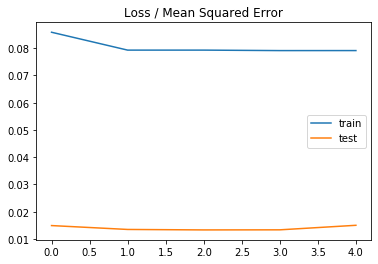

In [13]:
# lands_1.h5
from matplotlib import pyplot
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Test Model

In [47]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

img = image.load_img("roi_0006_234_176.png",target_size=(96,96), color_mode = "grayscale")
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)


In [48]:
img_data.shape

(1, 96, 96, 1)

In [49]:
from keras.models import load_model

saved_model = load_model("lands_1.h5")
output = saved_model.predict(img_data)
xs = output[0][0::2] * 96
ys = output[0][1::2] * 96

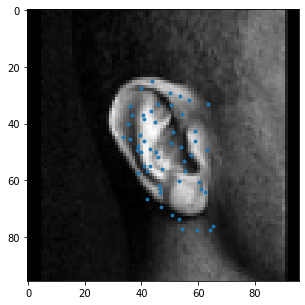

In [36]:
# Show image        
fig = plt.figure(figsize=(5, 5))
plt.scatter(xs, ys, s=8)
imgplot = plt.imshow(img, cmap = plt.cm.gray)
plt.show()

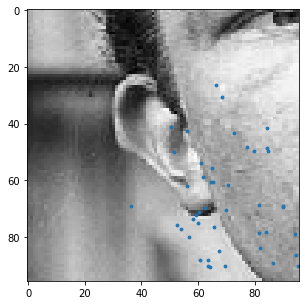

In [50]:
# Show image        
fig = plt.figure(figsize=(5, 5))
plt.scatter(xs, ys, s=8)
imgplot = plt.imshow(img, cmap = plt.cm.gray)
plt.show()

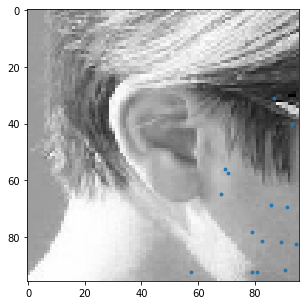

In [40]:
# Show image        
fig = plt.figure(figsize=(5, 5))
plt.scatter(xs, ys, s=8)
imgplot = plt.imshow(img, cmap = plt.cm.gray)
plt.show()

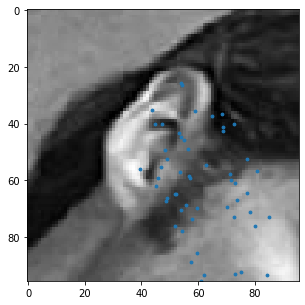

In [46]:
# Show image        
fig = plt.figure(figsize=(5, 5))
plt.scatter(xs, ys, s=8)
imgplot = plt.imshow(img, cmap = plt.cm.gray)
plt.show()

In [ ]:
train_mse

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
checkpoint = ModelCheckpoint("lands_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=100,generator=X, validation_data= y, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

Train: 0.003, Test: 0.008


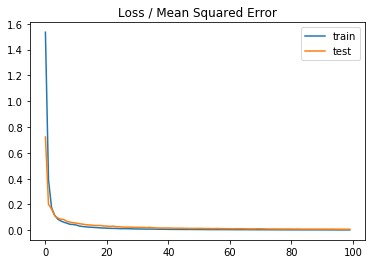

In [13]:
# mlp for regression with mse loss function
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# standardize dataset
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
trainX.shape, trainy.shape, testX.shape, testy.shape

((500, 20), (500,), (500, 20), (500,))

In [16]:
X.shape

(1000, 20)